# Library import

### import librerie

In [1]:
import os
import numpy as np

import json
from PIL import Image
from torch.utils.data import Dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

import ast

In [2]:
pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 8.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


## Path

In [3]:
# file contenente i path delle immagini del dataset
txt_file = "/kaggle/input/our-xview-dataset/xView_class_map.json"
img_dir = "/kaggle/input/our-xview-dataset/images"

annotation_file = "/kaggle/input/our-xview-dataset/COCO_annotations_new.json"

In [4]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils', trust_repo=True)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


# Dataloader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, utils, aug=False):
        """
        Args:
            annotations_file (str): Path al file JSON delle annotazioni (es. formato COCO).
            img_dir (str): Path alla directory delle immagini.
            utils: Funzioni di utilità per il dataset.
            aug (bool): Flag per attivare le trasformazioni di data augmentation.
        """
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.img_dir = img_dir
        self.utils = utils
        self.aug = aug
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converte in formato [C, H, W]
            transforms.Resize((320, 320)),  # Ridimensiona l'immagine
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        # Leggi i dettagli dell'immagine
        img_info = self.annotations['images'][idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # Caricamento immagine
        image = Image.open(img_path).convert("RGB")
        
        # Trasforma l'immagine
        if self.aug:
            #image = self.utils.augment(image)  # Applica data augmentation, se definita
            image = self.transform(image)

        # Check sul formato dell'immagine
        if not isinstance(image, torch.Tensor):
            raise ValueError(f"L'immagine non è un tensore: {type(image)}")
        if image.shape[0] != 3:
            raise ValueError(f"L'immagine ha un numero di canali errato: {image.shape[0]} (atteso: 3)")

        # Leggi le annotazioni
        img_id = img_info['id']
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_id]

        # Bounding box e label
        if len(annotations) == 0:
            bboxes = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
        else:
            bboxes = np.array(
                    [ast.literal_eval(ann['bbox']) if isinstance(ann['bbox'], str) else ann['bbox'] for ann in annotations],
                    dtype=np.float32
                )
            labels = np.array([ann['category_id'] for ann in annotations], dtype=np.int64)
            bboxes[:, 2:] += bboxes[:, :2]  # Converti nel formato (x_min, y_min, x_max, y_max)
            
        # Check sui bounding box
        if bboxes.ndim != 2 or bboxes.shape[1] != 4:
            raise ValueError(f"Bounding box in formato errato: {bboxes.shape} (atteso: [N, 4])")

        # Check sulle label
        if labels.ndim != 1:
            raise ValueError(f"Labels in formato errato: {labels.shape} (atteso: [N])")
        if not np.issubdtype(labels.dtype, np.integer):
            raise ValueError(f"Labels non sono interi: {labels.dtype}")

        # Costruzione del target
        target = {
            "image": image,
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
        }

        return target


In [6]:
def collate_fn(batch):
    # Separate images and targets from the batch
    images = [item['image'] for item in batch]
    targets = [item for item in batch]
    
    # Stack images into a tensor of shape (batch_size, C, H, W)
    images = torch.stack(images, dim=0)
    
    # Prepare boxes and labels lists
    boxes_list = [target['boxes'] for target in targets]
    labels_list = [target['labels'] for target in targets]
    
    # Return images and targets (without using stack)
    return images, [{'boxes': boxes, 'labels': labels} for boxes, labels in zip(boxes_list, labels_list)]

In [7]:
# Creazione dei dataset
train_dataset = CustomDataset(annotation_file, img_dir, utils, aug=True) 
valid_dataset = CustomDataset(annotation_file, img_dir, utils, aug=False)  
test_dataset = CustomDataset(annotation_file, img_dir, utils, aug=False)  

# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

boxes : tensor([[ 80.,   0., 162.,  67.],
        [138.,   0., 282., 116.],
        [292., 193., 319., 247.],
        [282., 274., 319., 306.],
        [ 94.,  54., 106.,  61.],
        [109.,  42., 125.,  50.],
        [ 86.,  40.,  97.,  45.],
        [  0.,  78., 210., 320.],
        [156., 288., 217., 320.],
        [278.,  56., 287.,  63.],
        [266., 296., 286., 320.],
        [125.,  23., 139.,  29.],
        [286.,  60., 295.,  75.],
        [175., 290., 189., 297.],
        [252., 292., 269., 321.],
        [ 97.,  42., 109.,  47.],
        [272., 285., 278., 297.],
        [174., 304., 185., 309.],
        [ 84.,  44.,  97.,  52.],
        [288., 246., 317., 277.],
        [298.,  80., 307.,  93.],
        [280., 296., 321., 319.],
        [288., 243., 302., 247.],
        [316., 249., 321., 281.],
        [298., 172., 320., 201.],
        [170., 316., 181., 320.],
        [316.,  85., 321., 121.],
        [107.,  52., 119.,  57.],
        [264., 281., 269., 293.],
      

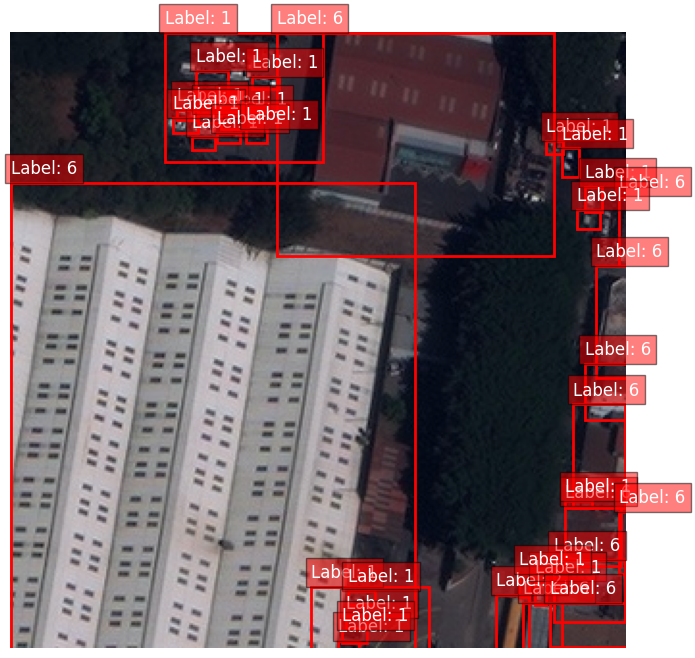

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_dataset_element(dataset, idx):
    """
    Visualizza un elemento specifico del dataset (immagine, bounding box e label).
    
    Args:
        dataset: Istanza del dataset.
        idx (int): Indice dell'elemento da visualizzare.
    """
    # Estrai un elemento dal dataset
    element = dataset[idx]
    image = element['image']
    boxes = element['boxes']
    labels = element['labels']

    print(f"boxes : {boxes}")
    print(f"labels : {labels}")
    
    # Converti l'immagine per la visualizzazione
    image = image.permute(1, 2, 0).numpy()  # Da [C, H, W] a [H, W, C]
    image = (image * 0.229 + 0.485).clip(0, 1)  # De-normalizzazione (assume mean/std standard)

    # Visualizza l'immagine
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Aggiungi i bounding box
    for bbox, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = bbox.numpy()
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x_min, y_min - 5, f"Label: {label.item()}",
            color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.axis('off')
    plt.show()

# Esempio di utilizzo
visualize_dataset_element(train_dataset, idx=2)  # Visualizza il primo elemento del dataset


# Network

In [10]:
class SSDModel(nn.Module):
    def __init__(self, num_classes):
        super(SSDModel, self).__init__()

        ## Model -> per info https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD
        self.ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd') # modello pre-addestrato su dataset COCO

    def forward(self, images):

        # Calcola le previsioni con il modello SSD
        predictions = self.ssd_model(images)  # Output grezzo del modello SSD
        
        return predictions

In [11]:
num_classes = 12
ssd_model = SSDModel(num_classes)

print(ssd_model)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s] 
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Detection/SSD/ssd/entrypoints.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `t

SSDModel(
  (ssd_model): SSD300(
    (feature_extractor): ResNet(
      (feature_extractor): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

# Training

In [9]:
class SSDLoss(nn.Module):
    
    def __init__(self):
        super(SSDLoss, self).__init__()
        self.smooth_l1 = nn.SmoothL1Loss(reduction='sum')  # Per bounding boxes
        self.cross_entropy = nn.CrossEntropyLoss(reduction='sum')  # Per classificazione

    def forward(self, predictions, targets):
        loc_preds, conf_preds = predictions
        loc_targets, conf_targets = targets
        
        # Calcola la perdita di regressione (bounding boxes)
        loc_loss = self.smooth_l1(loc_preds, loc_targets)
        
        # Calcola la perdita di classificazione (confidence scores)
        conf_loss = self.cross_entropy(conf_preds, conf_targets)
        
        # Restituisci la perdita combinata
        return loc_loss + conf_loss


In [15]:
from tqdm import tqdm

class Trainer:
    def __init__(self, model, dataloader, optimizer, loss_fn, num_epochs=10, device='cuda'):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.num_epochs = num_epochs
        self.device = device

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0

        pbar = tqdm(self.dataloader, desc="Training", ncols=100)
        for images, targets in pbar:  # Modifica per gestire il batch
            # Sposta dati su device
            images = images.to(self.device)
            targets = [
                {
                    'boxes': target['boxes'].to(self.device), 
                    'labels': target['labels'].to(self.device)
                } for target in targets
            ]

            # Inizializza il gradiente
            self.optimizer.zero_grad()

            # Calcola le predizioni
            loss_dict = self.model(images, targets)

            # Aggrega le perdite
            losses = sum(loss for loss in loss_dict.values())

            # Backpropagation
            losses.backward()
            self.optimizer.step()

            # Aggiorna la barra di progresso
            total_loss += losses.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})

        return total_loss / len(self.dataloader)

    def evaluate(self):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for images, targets in tqdm(self.dataloader, desc="Evaluating", ncols=100):
                # Sposta dati su device
                images = images.to(self.device)
                targets = [
                    {
                        'boxes': target['boxes'].to(self.device),
                        'labels': target['labels'].to(self.device)
                    } for target in targets
                ]

                # Calcola la perdita senza backpropagation
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

        return total_loss / len(self.dataloader)

    def train(self):
        train_losses = []
        val_losses = []

        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}")

            train_loss = self.train_one_epoch()
            val_loss = self.evaluate()

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses


In [18]:
# Addestra il modello, con validazione ad ogni epoca
loss = SSDLoss()

# Inizializza il trainer
trainer = Trainer(
    model=ssd_model,
    dataloader=train_loader,
    #val_dataloader=val_loader,
    loss_fn=loss,
    optimizer=Adam(ssd_model.parameters(), lr=1e-4),
    device='cuda'
)

# Avvia il training
train_losses, val_losses = trainer.train()

Epoch 1/10


Training:   0%|                                                            | 0/1435 [00:01<?, ?it/s]


TypeError: SSDModel.forward() takes 2 positional arguments but 3 were given

# Testing